In [1]:
from collections import defaultdict
import numpy as np
from itertools import combinations
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from matplotlib import pyplot as plt
import networkx as nx

In [2]:
def gen_cl_graph(n):
    G = nx.generators.classic.circular_ladder_graph(n)
    adj = nx.to_numpy_matrix(G)
    pos = nx.spring_layout(G)
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    plt.show()
    return G, adj
def gen_ml_graph(n):
    G = nx.generators.classic.circulant_graph(2*n, [1,n])
    adj = nx.to_numpy_matrix(G)
    pos = nx.spring_layout(G)
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    plt.show()
    return G, adj
def maxcut_hamiltonian_eigenvalue(G):
    # The Hamiltonian is H = sum(Pauli_Z(i) x Pauli_Z(j) - I)/2
    # The eigenvalue is the negation of the edges in cut solution
    # D-wave will minimize the energy of the Hamiltonian
    # The QUBO should be -xi-xj+2xixj
    # The corresponding Q matrix is as follows
    Q = defaultdict(int)
    for u, v in G.edges:
        #should be -1 & -2, but use -0.5 & 1 so we are not overcounting twice xi_xj and xj_x_i
        Q[(u,u)]+= -0.5 
        Q[(v,v)]+= -0.5
        Q[(u,v)]+= 1
    return Q
def hen_young_hamiltonian_eigenvalue(G):
    # The Hamiltonian is H = sum(Pauli_Z(i) x Pauli_Z(j))
    # D-wave will minimize the energy of the Hamiltonian
    # The QUBO should be -2xi-2xj+4xixj+1-->1 cannot formulate, 
    # I will be using the matrix of the Hamiltoian directly
    # The corresponding Q matrix is as follows
    Q = defaultdict(int)
    P_z = np.array([[1,0],[0,-1]])
    H = np.zeros((2**len(G.nodes),2**len(G.nodes)))
    I = np.identity(2)
    for u, v in G.edges:
        zu = P_z
        zv = P_z
        if u < v: #There will be no loop and edges are not directed
            print(u,v)
            for i in range(u):
                #zu = np.kron(I, zu)
                zu = (I[:, None, :, None]*zu[None, :, None, :]).reshape(2**(i+2),2**(i+2))
                print("Zu",zu.shape)
            for j in range(v-u-1):
                #zv = np.kron(I, zv)
                zv = (I[:, None, :, None]*zv[None, :, None, :]).reshape(2**(j+2),2**(j+2))
            #zu = np.kron(zu, zv)
            zu = (zu[:, None, :, None]*zv[None, :, None, :]).reshape(2**(v+1),2**(v+1))
            print("Zu",zu.shape)
            for k in range(v+1, len(G.nodes)):
                #zu = np.kron(zu, I)
                zu = (zu[:, None, :, None]*I[None, :, None, :]).reshape(2**(k+1),2**(k+1))
                print("Zu",zu.shape)
            H += zu
    for i in range(len(H)):
        for j in range(len(H)):
            Q[(i,j)]=H[i,j]
    return Q

def solve(Q, chainstrength=8, numruns=10):
    # Run the QUBO on the solver from your config file
    sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))
    response = sampler.sample_qubo(Q, chain_strength=chainstrength, num_reads=numruns)
    energies = iter(response.data())

    return [e.energy for e in list(energies)]

/Users/victorli/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


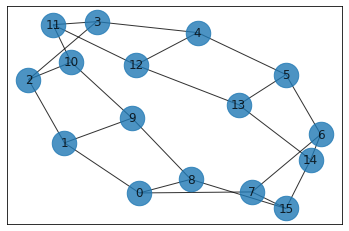

In [17]:
cl, adj_cl = gen_cl_graph(8)
Q_cl_maxcut = maxcut_hamiltonian_eigenvalue(cl)
#Q_cl_hen_young = hen_young_hamiltonian_eigenvalue(cl)

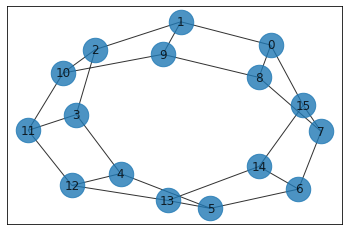

In [18]:
ml, adj_ml = gen_ml_graph(8)
Q_ml_maxcut = maxcut_hamiltonian_eigenvalue(ml)
#Q_ml_hen_young = hen_young_hamiltonian_eigenvalue(ml)

### Hen & Young hypothesized that Q2 along the adiabatic evolution will be a good differentiator for isomorphism
I suppose that the expectation involved in Q2 is with respect to the sampled vector with the least energy at a certain point during evolution. Here let's just try to use $E[H] = min(\lambda)$ when s=1 since they had the best result at s=1 anyways, we will switch to Q2 later

In [21]:
numruns = 30
e_cl = solve(Q_cl_maxcut, numruns = numruns)[::-1] #revert because the first energy in the iter is the last
e_ml = solve(Q_ml_maxcut, numruns = numruns)[::-1]

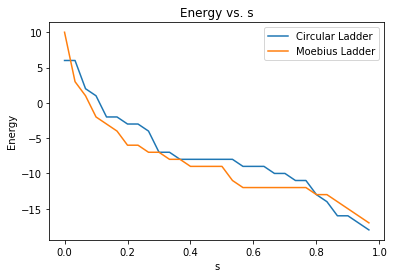

In [22]:
fig, ax = plt.subplots()
ax.plot(np.arange(0.0, 1.0, 1/numruns), e_cl,label="Circular Ladder")
ax.plot(np.arange(0.0, 1.0, 1/numruns), e_ml,label="Moebius Ladder")
ax.set_xlabel("s")
ax.set_ylabel("Energy")
ax.set_title("Energy vs. s")
ax.legend()

In [16]:
numruns = 50
e_cl = solve(Q_cl_hen_young, numruns = numruns)[::-1] #revert because the first energy in the iter is the last
e_ml = solve(Q_ml_hen_young, numruns = numruns)[::-1]

ValueError: no embedding found

In [21]:
fig, ax = plt.subplots()
ax.plot(np.arange(0.0, 1.0, 1/numruns), e_cl,label="Circular Ladder")
ax.plot(np.arange(0.0, 1.0, 1/numruns), e_ml,label="Moebius Ladder")
ax.set_xlabel("s")
ax.set_ylabel("Energy")
ax.set_title("Energy vs. s")
ax.legend()

[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1. -0.  0.  0. -0. -0.]
 [ 0.  0. -0. -1.  0.  0. -0. -0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0. -0. -0.  0.  0. -1. -0.]
 [ 0.  0. -0. -0.  0.  0. -0. -1.]]


ValueError: cannot reshape array of size 32 into shape (8,8)

In [14]:
a = np.identity(2)
b = np.array([[1,0],[0,-1]])
ab = np.kron(a,b)
abb = (a[:, None, :, None]*b[None, :, None, :]).reshape(4,4)
print(abb)

[[ 1.  0.  0.  0.]
 [ 0. -1.  0. -0.]
 [ 0.  0.  1.  0.]
 [ 0. -0.  0. -1.]]
